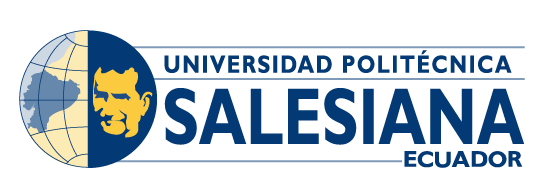

### Roberto Pacho

### Covid-19-RegresiónTotal

# Covid-19 infección en Ecuador. Modelos matemáticos y predicciones
Una comparación de modelos, lineal, polilnomico,logísticos y exponenciales aplicados a la infección por el virus Covid-19

Se realiza un análisis matemático simple del crecimiento de la infección en Python y dos modelos para comprender mejor la evolución de la infección.

Se crea modelos de series temporales del número total de personas infectadas hasta la fecha (es decir, las personas realmente infectadas más las personas que han sido infectadas). Estos modelos tienen parámetros , que se estimarán por ajuste de curva.

In [4]:
# Importar las librerias para el analasis
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline


In [5]:
# Actualizar los datos (URL)

url = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'

df = pd.read_csv(url)
df

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index,excess_mortality
0,AFG,Asia,Afghanistan,2020-02-24,1.0,1.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
1,AFG,Asia,Afghanistan,2020-02-25,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
2,AFG,Asia,Afghanistan,2020-02-26,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
3,AFG,Asia,Afghanistan,2020-02-27,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
4,AFG,Asia,Afghanistan,2020-02-28,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83,0.511,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94436,ZWE,Africa,Zimbabwe,2021-06-04,39144.0,52.0,32.286,1605.0,1.0,1.857,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
94437,ZWE,Africa,Zimbabwe,2021-06-05,39168.0,24.0,33.571,1605.0,0.0,1.571,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
94438,ZWE,Africa,Zimbabwe,2021-06-06,39189.0,21.0,35.000,1606.0,1.0,1.714,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN
94439,ZWE,Africa,Zimbabwe,2021-06-07,39238.0,49.0,39.571,1611.0,5.0,2.429,...,21.4,307.846,1.82,1.6,30.7,36.791,1.7,61.49,0.571,NaN


Imprimos los resultados y agregamos el numero del dia


In [6]:
df = df[df['location'].isin(['Ecuador'])] #Filtro la Informacion solo para Ecuador
df = df.loc[:,['date','total_cases']] #Selecciono las columnas de analasis
# Expresar las fechas en numero de dias desde el 01 Enero
FMT = '%Y-%m-%d'
date = df['date']
df['date'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01", FMT)).days)

df

,date,total_cases
24720,60,6.0
24721,61,6.0
24722,62,7.0
24723,63,10.0
24724,64,13.0
...,...,...
25180,520,430739.0
25181,521,431429.0
25182,522,432353.0
25183,523,432739.0


<AxesSubplot:xlabel='date'>

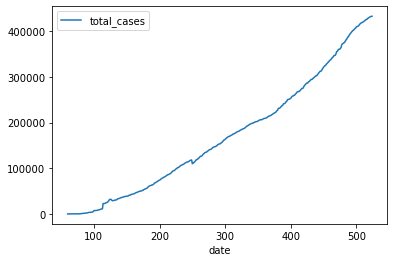

In [7]:
df.plot(x ='date', y='total_cases')

Ahora podemos analizar los cuatro modelos que tomaré en el examen, que son la función lineal, polinomica,logística y la función exponencial . Cada modelo tiene tres parámetros , que se estimarán mediante un cálculo de ajuste de curva en los datos históricos.

## EL modelo lineal

La regresión lineal es un algoritmo de aprendizaje supervisado que se utiliza en Machine Learning y en estadística. En su versión más sencilla, lo que haremos es «dibujar una recta» que nos indicará la tendencia de un conjunto de datos continuos.

Recordemos rápidamente la fórmula de la recta:

Y = mX + b

Donde Y es el resultado, X es la variable, m la pendiente (o coeficiente) de la recta y b la constante o también conocida como el «punto de corte con el eje Y» en la gráfica (cuando X=0)
Ejemplo


Recordemos que los algoritmos de Machine Learning Supervisados, aprenden por sí mismos y -en este caso- a obtener automáticamente esa «recta» que buscamos con la tendencia de predicción. Para hacerlo se mide el error con respecto a los puntos de entrada y el valor «Y» de salida real.



In [8]:
x = list(df.iloc [:, 0]) # Fecha
y = list(df.iloc [:, 1]) # Numero de casos
# Creamos el objeto de Regresión Lineal
regr = linear_model.LinearRegression()
 
# Entrenamos nuestro modelo
regr.fit(np.array(x).reshape(-1, 1) ,y)

# Veamos los coeficienetes obtenidos, En nuestro caso, serán la Tangente
print('Coefficients: \n', regr.coef_)
# Este es el valor donde corta el eje Y (en X=0)
print('Independent term: \n', regr.intercept_)
# Error Cuadrado Medio

Coefficients: 
 [937.50345544]
Independent term: 
 -103667.07135316456


De la ecuación de la recta y = mX + b nuestra pendiente «m» es el coeficiente y el término independiente «b»


In [9]:
#Vamos a comprobar:
# Quiero predecir cuántos "Casos" voy a obtener por en el dia 100,
# según nuestro modelo, hacemos:
y_prediccion = regr.predict([[100]])
print(int(y_prediccion))

-9916


[50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73
 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97
 98 99]


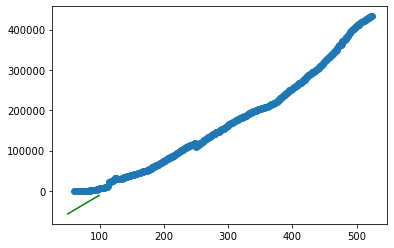

In [10]:
#Graficar
plt.scatter(x, y)
x_real = np.array(range(50, 100))
print(x_real)
plt.plot(x_real, regr.predict(x_real.reshape(-1, 1)), color='green')
plt.show()



## El modelo logistico

El modelo logístico se ha utilizado ampliamente para describir el crecimiento de una población. Una infección puede describirse como el crecimiento de la población de un agente patógeno, por lo que un modelo logístico parece razonable .
La expresión más genérica de una función logística es:

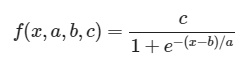

En esta fórmula, tenemos la variable x que es el tiempo y tres parámetros: a, b, c .

- a se refiere a la velocidad de infección
- b es el día en que ocurrieron las infecciones máximas
- c es el número total de personas infectadas registradas al final de la infección
 


Ejemplo de regresion logistica
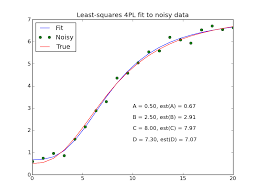

Definamos la función en Python y realicemos elprocedimiento de ajuste de curva utilizado para el crecimiento logístico.

In [11]:
def modelo_logistico(x,a,b):
    return a+b*np.log(x)

exp_fit = curve_fit(modelo_logistico,x,y) #Extraemos los valores de los paramatros
print(exp_fit)


(array([-983481.09908004,  208189.36629456]), array([[ 5.42184639e+08, -9.68528316e+07],
       [-9.68528316e+07,  1.74794909e+07]]))


## Gráficas

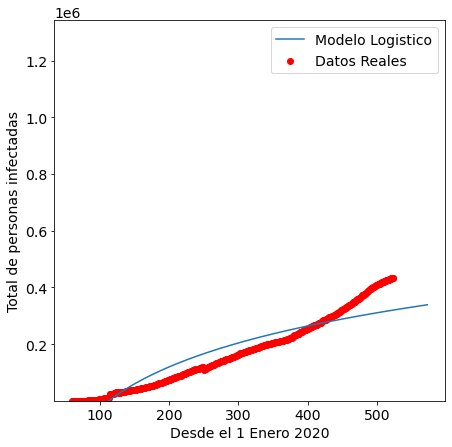

In [12]:
pred_x = list(range(min(x),max(x)+50)) # Predecir 50 dias mas
plt.rcParams['figure.figsize'] = [7, 7]
plt.rc('font', size=14)
# Real data
plt.scatter(x,y,label="Datos Reales",color="red")
# Predicted exponential curve
plt.plot(pred_x, [modelo_logistico(i,exp_fit[0][0],exp_fit[0][1]) for i in pred_x], label="Modelo Logistico" )
plt.legend()
plt.xlabel("Desde el 1 Enero 2020")
plt.ylabel("Total de personas infectadas")
plt.ylim((min(y)*0.9,max(y)*3.1)) # Definir los limites de Y
plt.show()

## Modelo exponencial

Mientras que el modelo logístico describe un crecimiento de infección que se detendrá en el futuro, el modelo exponencial describe un crecimiento de infección imparable . Por ejemplo, si un paciente infecta a 2 pacientes por día, después de 1 día tendremos 2 infecciones, 4 después de 2 días, 8 después de 3 y así sucesivamente.
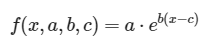

Ejemplo de regresion exponencial
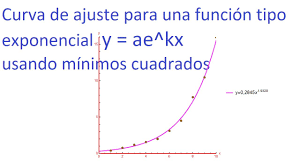

[0.01211908 7.72178371]


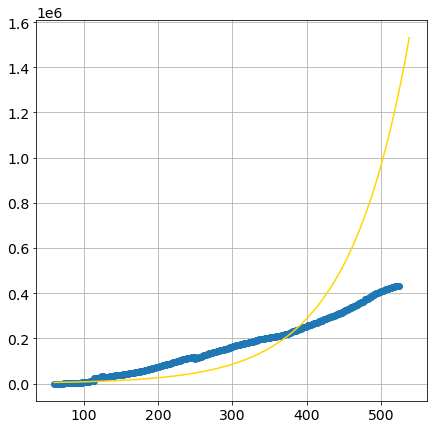

In [13]:
# Implementar
curve_fit = np.polyfit(x, np.log(y), deg=1)
print(curve_fit)
pred_x = np.array(list(range(min(x), max(x)+15)))
yx = np.exp(curve_fit[1]) * np.exp(curve_fit[0]*pred_x)
plt.plot(x,y,"o")
plt.plot(pred_x,yx, color="gold")
plt.grid(True)

## Modelo polinomial
Predicción de una variable de respuesta cuantitativa a partir de una variable predictora cuantitativa, donde la relación se modela como una función polinomial de orden n (esto significa que pueden tener de diferentes exponenciales o grados y se debe ir probando)  

Se puede tener una ecuacion con diferentes grados

y = a0 + a1x + a2x^2 + a3x^3 + … + anx^n + ε

Ejemplo de una regresion polinomica de grado 4.
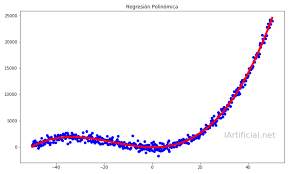


Función Resultado
           4           3         2
1.536e-05 x - 0.01581 x + 6.498 x - 412.4 x + 259.1


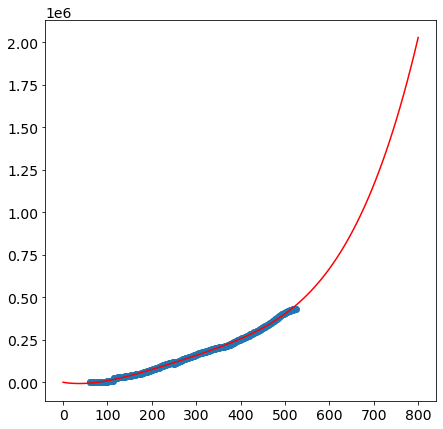

In [14]:
# Implementar 


# Se puede implementar modelos adicionales o conversion de datos 
# Se tomara como puntos adicionales a las practicas.

# calculamos la curva polinomica de 4 grado que se ajusta a los datos  
# usando la funcion polyfit  

p4 = np.poly1d(np.polyfit(x, y, 4))
print("Función Resultado")
print(p4)
# pintamos la muestra y la funcion polinomica en rojo para ver como se ajusta  
import matplotlib.pyplot as plt

xp = np.linspace(0, 800, 100)  
plt.scatter(x, y)  
plt.plot(xp, p4(xp), c='r')  
plt.show()

## Número de Casos

           4           3         2
1.536e-05 x - 0.01218 x + 4.021 x + 201.9 x - 4511


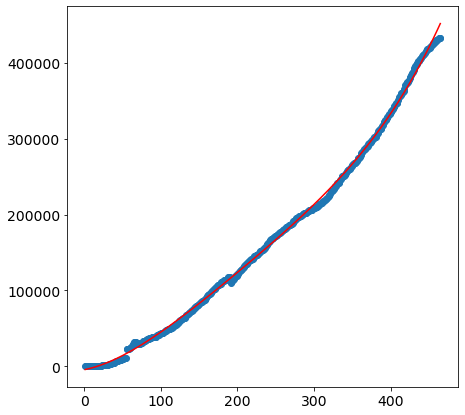

In [15]:

df = pd.read_csv('https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv').fillna(0) # poniendo datos nan a cero
ndf= df.loc[(df['location'] == 'Ecuador') & (df['total_cases'] != 0)] # filtrando por pais y no ceros 
ndf1=ndf[['date','total_cases','total_deaths']]
x=np.arange(1,len(ndf1)+1,1, dtype='float') # arreglo de x lo creo para simular el numero del dia y el numero de casos
y=np.array(ndf1.values[:,1], dtype='float')
y1=np.array(ndf1.values[:,2],dtype='float')

# Numero de Casos
fun1 = np.poly1d(np.polyfit(x, y, 4))
print(fun1)
plt.scatter(x, y)  
plt.plot(x, fun1(x), c='r')  
plt.show()
#ndf1

## Número de Muertes

           4            3          2
2.852e-06 x - 0.002734 x + 0.8175 x - 30.53 x + 410.8


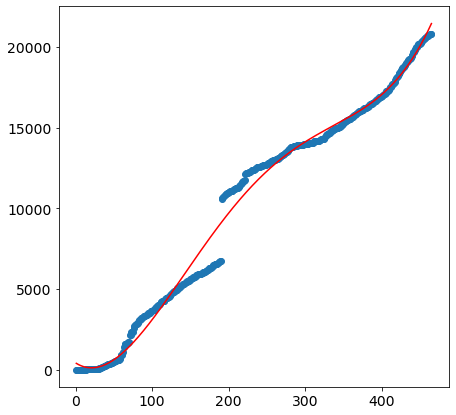

In [16]:
fun1 = np.poly1d(np.polyfit(x, y1, 4))
print(fun1)
plt.scatter(x, y1)  
plt.plot(x, fun1(x), c='r')  
plt.show()

## Analisis

Mediante los modelos de regresión se puede hacer un análisis sobre los contagios de covid-19, haciendo que este podria definir cual serial el mejor modelo para la prediccion

## Conclusiones

mediante el desarrollo de este trabajo emos podido ir observando que obtiene un menor grado de error mediante el módelo polinómico.

## Criterio personal (politico, economico y  social de la situacion)

- A lo largo del tiempo de duracion de la pandemia al tiempo actual emos podido ver que nuestro pais no estubo ni esta preparado para controlar una enfermedad tan masiva la misma que a llevado al pais a perdidas economicas y humanas.  
- En cuanto al aspecto economico empero en en el inicio y en el punto maximo de contagios ya que la gente se aprobecha de las las necesidades de las personas como en alimentos e insumos al igual que de las empresas privadas que se aprobecharon de la situacion para generar despidos masivos.  

- En lo social en algunos sectores del pais la jente fue compresible quedandoce en casa para evitar la propagacion del mismo esto evito en algunos sectores del pais caer en crisis de afectados sin enbargo en los lugares en donde no respetaban el toque de queda matubo una crisis de afectados llenando hospitales. 

# Referencias

- https://www.researchgate.net/publication/340092755_Infeccion_del_Covid-19_en_Colombia_Una_comparacion_de_modelos_logisticos_y_exponenciales_aplicados_a_la_infeccion_por_el_virus_en_Colombia

- https://www.aprendemachinelearning.com/regresion-lineal-en-espanol-con-python/

